# Wyszukiwanie wzorca 2D

In [69]:
import pandas as pd
from PIL import Image
from time import time
import matplotlib.pyplot as plt

Zadanie dotyczy wyszukiwania wzorców dwuwymiarowych.

# 1. Zaimplementuj algorytm wyszukiwania wzorca 2-wymiarowego 

Poniższa funkcja przetwarza wzorzec 2D i zwraca informacje:

<ul>
    <li>columns: lista krotek reprezentujących kolumny wzorca, </li>
    <li>indexes: lista indeksów, które wskazują, do której kolumny w columns odpowiada dana kolumna wzorca,  </li>
    <li> alphabet: zbiór unikalnych elementów (liter) występujących we wszystkich kolumnach wzorca. </li>
</ul>

In [70]:
def get_columns(pattern):
    columns, indexes, alphabet = [], [], set()
    
    for column in zip(*pattern): # transponuje wzorzec, tworząc krotki reprezentujące kolumny. 
        if column in columns:
            index = columns.index(column)
            indexes.append(index)
        else:
            columns.append(column)
            indexes.append(len(columns) - 1)
        
        alphabet.update(column)
    
    return columns, indexes, alphabet

Funkcje tworzące automat - pionowo i poziomo.

In [71]:
def vertical(columns, alphabet):
    transition_table, words, states = [{}], [[]], [0] * len(columns)
    
    for j, column in enumerate(zip(*columns)): # Przechodzimy po kolumnach
        for i, letter in enumerate(column):
            
            # Sprawdza, czy letter znajduje się już w transition_table[states[i]].
            
            # Jeśli tak, 
            # aktualizuje stan states[i] na odpowiadający tej literze stan w transition_table[states[i]]
            
            if letter in transition_table[states[i]]:
                states[i] = transition_table[states[i]][letter]
                
            # Jeśli nie,
            # dodaje nowy stan new_state na końcu transition_table
            # i przypisuje go do transition_table[states[i]][letter]. 
            # Dodaje również nowe słowo do words, które jest konkatenacją 
            # słowa dla aktualnego stanu words[states[i]] i letter.
            # Następnie aktualizuje stan states[i] na new_state.
            
            else:
                new_state = len(transition_table)
                transition_table[states[i]][letter] = new_state
                words.append(words[states[i]] + [letter])
                states[i] = new_state
                transition_table.append({})
                
    for i, state in enumerate(transition_table):
        for letter in alphabet:
            if letter not in state:
                
                # Sprawdza, czy litera letter z alfabetu wzorca nie znajduje się w stanie state.
                # Jeśli tak, tworzy sufiks suffix, który jest konkatenacją
                # aktualnego słowa words[i] i letter bez pierwszego elementu. 
                # Następnie inicjalizuje current_state na 0
                
                suffix = (words[i] + [letter])[1:]
                current_state = 0
                
                # Iteruje po literach s w suffix. Sprawdza, czy s znajduje się w transition_table[current_state]. 
                # Jeśli tak, aktualizuje current_state na odpowiadający tej literze stan 
                # w transition_table[current_state]. W przeciwnym razie ustawia current_state na 0.
                
                for s in suffix:
                    current_state = transition_table[current_state].get(s, 0)

                        
                transition_table[i][letter] = current_state  
                               
    return transition_table, states 

In [72]:
def horizontal(pattern, alphabet):
    automat = []

    for state in range(len(pattern) + 1): # pętla dla każdego stanu
        automat.append({})
        for letter in alphabet:
            
            # Inicjujemy następny stan next_state - jest on równy
            # obecnemu stanowi + 1 albo dlugosci wzorca, jeśli jest on mniejszy.
            
            next_state = state + 1
            
            if next_state > len(pattern):
                next_state = len(pattern)
                
            #  # W pętli dopóki następny stan jest większy od zero tworzymy dwie zmienne - prefiks i sufiks.
            # Porównujemy prefix i suffix. Jeśli są one równe, to znaczy, 
            # że znaleziono dopasowanie między prefiksem a sufiksem, dlatego przerywamy pętlę.
            # W przeciwnym razie zmniejszamy next_state o 1.
            
            while next_state > 0:
                prefix = pattern[:state] + [letter]
                suffix = pattern[state - next_state + 1:state + 1]

                if prefix == suffix:
                    break

                next_state -= 1

            automat[state][letter] = next_state

    return automat # zwracamy wynikowy automat

Główny algorytm wyszukiwania wzorca 2D

In [73]:
def pattern_2d(text, pattern, times = False):
    start = time()
    columns, idxs, alphabet = get_columns(pattern)
    
    # tworzone są tablica przejść vertical_tt oraz początkowy stan pionowy vertical_states
    # Tworzona jest lista pattern_, która jest transformacją indeksów kolumn wzorca pattern 
    # na odpowiadające stany z tablicy przejść
    vertical_tt, vertical_states = vertical(columns, alphabet)
    pattern_ = [vertical_states[idxs[i]] for i in range(len(idxs))]
    
    # na podstawie listy pattern_ oraz stanów pionowych vertical_states tworzona jest tablica
    # przejść horizontal_tt dla stanów poziomych
    # Obliczany jest stan akceptujący poziomy horizontal_accepting_state
    horizontal_tt = horizontal(pattern_, vertical_states)
    horizontal_accepting_state = len(horizontal_tt) - 1
    
    result, vertical_states = [], []

    # iterujemy po liniach line tekstu ( i ich indeksach oznaczonych jako i)

    end = time()
    time1 = end - start # czas przygotowania automatu
    
    start = time()
    
    for i, line in enumerate(text):
        
        # Sprawdzane jest, czy długość linii jest mniejsza od długości stanów 
        # pionowych len(vertical_states). 

        # Jeśli tak, to stan pionowy jest przycinany
        # do długości linii za pomocą vertical_states[:len(line)]. Jeśli długość linii
        # jest większa od stanów pionowych, to są dodawane brakujące zera do vertical_states
        # przy pomocy vertical_states.extend([0] * (len(line) - len(vertical_states)))
    
        if len(line) < len(vertical_states): vertical_states = vertical_states[:len(line)]
        elif len(vertical_states) < len(line): vertical_states.extend([0] * (len(line) - len(vertical_states)))

        horizontal_state = 0 #  Będzie przechowywać aktualny stan poziomy.
        
        for j, letter in enumerate(line): # iteracja po literach w aktualnej linii tekstu
            
            # Stan pionowy vertical_states[j] i stan poziomy horizontal_state są aktualizowane
            vertical_states[j] = vertical_tt[vertical_states[j]].get(letter, 0)
            horizontal_state = horizontal_tt[horizontal_state].get(vertical_states[j], 0)
            
            # Jeśli horizontal_state osiąga wartość horizontal_accepting_state, oznacza to,
            # że wzorzec został dopasowany w danym fragmencie tekstu. W takim przypadku, 
            # para indeksów (i - len(pattern) + 1, j - len(pattern[0]) + 1) jest dodawana 
            # do listy wynikowej result.

            # Jeśli horizontal_state osiąga wartość 0, kontynuowana jest iteracja do następnej
            # litery w linii tekstu.
            
            if horizontal_state == horizontal_accepting_state: 
                result.append((i - len(pattern) + 1, j - len(pattern[0]) + 1))
                
            elif horizontal_state == 0: continue
                
    end = time()
    time2 = end - start# czas wyszukiwania wzorca
    
    if not times:
        return result
    else:
        return time1, time2

# 2. Znajdź w załączonym pliku "haystack.txt" wszyskie sytuacje, gdy taka sama litera występuje na tej samej pozycji w dwóch kolejnych linijkach. Zwróć uwagę, na nierówną długość linii w pliku. 

In [74]:
def get_dataframe(filename = "haystack.txt"):
    with open(filename, 'r') as file:
        text = file.readlines()
        
    results = []
    
    for i in range(ord('a'), ord('z')+1):
        
        pattern = [chr(i), chr(i)]
        result = pattern_2d(text, pattern)
        
        if len(result) > 0:
            results.append([pattern[0], result])
        else:
            results.append([pattern[0], "No matches found"])
            
    return pd.DataFrame(results, columns=['Pattern', 'Matches'])


df = get_dataframe()
df

,Pattern,Matches
0,a,"[(0, 82), (3, 30), (5, 60), (6, 63), (20, 6), ..."
1,b,No matches found
2,c,"[(3, 54), (10, 45), (13, 10), (41, 0), (68, 0)..."
3,d,"[(37, 19)]"
4,e,"[(0, 63), (1, 8), (4, 77), (7, 65), (10, 1), (..."
5,f,"[(30, 59), (77, 1)]"
6,g,No matches found
7,h,"[(27, 2), (37, 2), (56, 31), (73, 12)]"
8,i,"[(1, 5), (8, 37), (9, 60), (19, 55), (31, 0), ..."
9,j,No matches found


# 3. Znajdź wszystkie wystąpienia "th" oraz "t h" w dwóch kolejnych liniach na tej samej pozycji. 

In [75]:
def find_th():
    with open('haystack.txt') as file:
        text = file.readlines()
        
    pattern = ["th", "th"]
    result = pattern_2d(text, pattern)
    
    print("----------------------------------------------")
    print("For th pattern: ")
    if result != []:
        print(result)
    else:
        print("No matches found.")
    
    pattern = ["t h", "t h"]
    result = pattern_2d(text, pattern)
    
    print("----------------------------------------------")
    print("For t h pattern: ")
    if result != []:
        print(result)
    else:
        print("No matches found.")
    
find_th()

----------------------------------------------
For th pattern: 
No matches found.
----------------------------------------------
For t h pattern: 
[(37, 0)]


# 4. Wybierz przynajmniej 4 litery (małe). Znajdź wszystkie wystąpienia tej litery w załączonym pliku "haystack.png" 

<p> Wybrane litery: </p>



<div style="display: flex; flex-direction: column;">
    <img src="a.png">
    <img src="o.png">
    <img src="e.png">
    <img src="c.png">
</div>

Na początku tworzę funkcję, która skonwertuje obraz na macierz zawierającą dane o pikselach. Będzie ona potrzebna aby móc wywołać zaimplementowany w zadaniu 1 algorytm wyszukiwania wzorca 2D.

In [76]:
def get_image_pattern(path):
    image = Image.open(path).convert("L")  # Konwersja obrazu na skalę szarości
    width, height = image.size
    matrix = []

    for y in range(height):
        row = []
        for x in range(width):
            pixel = image.getpixel((x, y))
            row.append(pixel)
        matrix.append(row)

    return matrix

Przygotowanie danych:

In [77]:
a = get_image_pattern("a.png")
o = get_image_pattern("o.png")
e = get_image_pattern("e.png")
c = get_image_pattern("c.png")
text = get_image_pattern("haystack.png")

Badanie liczby wystąpień:

In [78]:
def get_occurences():
    result = []
    result.append(["a", len(pattern_2d(text, a))])
    result.append(["o", len(pattern_2d(text, o))])
    result.append(["e", len(pattern_2d(text, e))])
    result.append(["c", len(pattern_2d(text, c))])

    return pd.DataFrame(result, columns=['Letter', 'Matches'])

df = get_occurences()
df

,Letter,Matches
0,a,175
1,o,0
2,e,14
3,c,81


# 5. Znajdź wszystkie wystąpienia słowa "p a t t e r n" w haystack.png. 

In [79]:
pattern = get_image_pattern("pattern.png")
occurences = pattern_2d(text, pattern)
print("Wystąpienia słowa 'pattern':")
print(occurences)

Wystąpienia słowa 'pattern':
[(494, 425), (538, 239), (582, 139)]


# 6. Porównaj czas budowania automatu i czas wyszukiwania dla różnych rozmiarów wzorca 

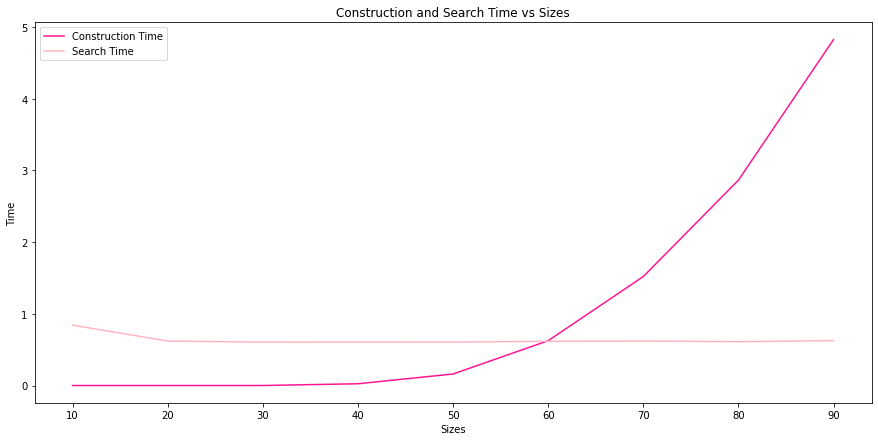

In [80]:
text = get_image_pattern("haystack.png")
construction, search = [], []
sizes = [i for i in range(10,100,10)]

for size in sizes:
    pattern = [i[0:size] for i in text[0:size]]
    time1, time2 = pattern_2d(text, pattern, True)
    construction.append(time1)
    search.append(time2)
    
# Tworzenie wykresu
plt.figure(figsize=(15, 7))
plt.plot(sizes, construction, color='deeppink', label='Construction Time')
plt.plot(sizes, search, color='lightpink', label='Search Time')

plt.xlabel('Sizes')
plt.ylabel('Time')
plt.title('Construction and Search Time vs Sizes')

plt.legend()
plt.show()


<ol> 
     <li> Czas budowania automatu rośnie liniowo wraz z rozmiarem wzorca. </li>
     <li> Czas wyszukiwania wzorca jest stały. Można się tego spodziewać, ponieważ zależy on od długości tekstu, a ten pozostaje przez cały czas taki sam. </li>
     <li> Czas budowania automatu jest dłuższy od czasu wyszukiwania wzorca ponieważ tabela przejścia zależy od alfabetu.</li>
</ol>

# 7. Podziel plik na 2, 4 i 8 fragmentów (w poziomie) i porównaj czas przeszukiwania 

In [95]:
text = get_image_pattern("haystack.png")
pattern = [line[:25] for line in text[:25]]

for part in [2,4,8]:
    
    part_size = len(text) // part
    parts = [text[i * part_size : (i + 1) * part_size] for i in range(part)]

    start = time()
    
    for ntext in parts:
        pattern_2d(ntext, pattern)
        
    end = time()

    print(f"Dla Liczby fragmentów {part} czas wyszukiwania wzorca to {round(end - start, 4)} sekund")

Dla Liczby fragmentów 2 czas wyszukiwania wzorca to 0.6307 sekund
Dla Liczby fragmentów 4 czas wyszukiwania wzorca to 0.6264 sekund
Dla Liczby fragmentów 8 czas wyszukiwania wzorca to 0.6102 sekund


<ul>
    <li>Pomimo podziału pliku na kilka fragmentów, czas wyszukiwania wzorca pozostaje praktycznie ten sam (zaobserwowane różnice są nieznaczne).</li>
</ul>